<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/changes/faceDetecting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import cv2
import numpy as np
from google.colab import drive
from PIL import Image
 
#подключение гугл-диска
drive.mount('/content/drive')
 
#сгрузим пути к данным в один массив
# наставим костылей, чтобы грузить меньше данных
"""directories = ['/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_test.zip',
               '/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_train.zip',
               '/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_val.zip']"""
directories = ['/content/drive/My Drive/Курсач/WIDER_FACE (zip)/WIDER_train.zip']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#распакуем архивы из гугл диска
z = []
for zips in directories:
  z.append(zipfile.ZipFile(zips,'r'))
 
for archives in z:
  archives.extractall()
 
# ещё костыль
#list_dir= ['WIDER_test/images', 'WIDER_train/images', 'WIDER_val/images']
list_dir =['WIDER_train/images']

In [3]:
#загружаем все изображения и конвертируем их в ч/б 
def upload(dir_num): #img_names):
  list_name = []
  list_dirs = os.listdir(list_dir[dir_num])
  #list_dirs.sort(key=lambda  list_dirs: int( list_dirs.split('-')[0]))
  list_dirs.sort()
  for cur_dir in list_dirs:
    list_file = os.listdir(os.path.join(list_dir[dir_num], cur_dir))
    list_file.sort()
    for cur_file in list_file:
      img = Image.open(os.path.join(list_dir[dir_num], cur_dir, cur_file)).convert("L")
      list_name.append(img)
      #img_names.append(cur_file)
      #тут тоже костыль
      if (len(list_name)==6440):
        return list_name
 

#img_names = []
#test=[]
train = upload(0)
#val = []

print(train[0].format, train[0].size, train[0].mode)

None (1024, 732) L


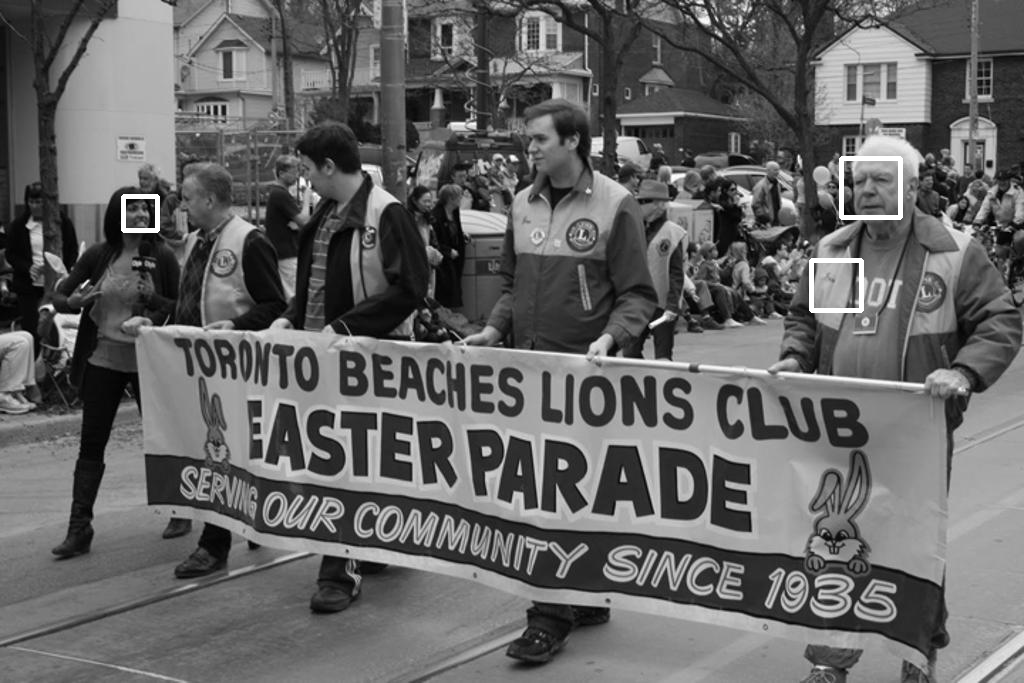

In [81]:
#здесь можно просто поиграться:)
import matplotlib.pyplot as plt
faceCascade = cv2.CascadeClassifier('/content/drive/My Drive/Курсач/files/haarcascade_frontalface_default.xml')
 
test_img = np.array(train[7],'uint8')
 
# Детектим лица
faces = faceCascade.detectMultiScale(test_img,scaleFactor=1.1,minNeighbors=5,flags=cv2.CASCADE_SCALE_IMAGE)
# Для каждого найденного лица
for (x, y, w, h) in faces: 
    # Рисуем красивые прямоугольнички
    cv2.rectangle(test_img, (x, y), (x+w, y+h), (255, 255, 255), 3)
 
test_img = Image.fromarray(test_img)
test_img

#Загрузка рамок  
  В данном блоке осуществляется загрузка рамок с лицами. Сначала мы просто прочитаем txt файл, затем полученные данные нужно отсортить лексикографически по имени файла, тк порядок файлов в txt не совпадает с порядком хранения наших картинок (поэтому будем приводить всё к одному формату хранения с помощью сортировок)   
  
    
The format of txt ground truth.  
File name  
Number of bounding box  
x1, y1, w, h, blur, expression, illumination,   invalid, occlusion, pose  

Также, поскольку на прошлом этапе мы уменьшили train[ ] вдвое, часть рамок нам уже не понадобится

In [12]:
#загрузим рамки 
frames = []

try:
  #открываем нужный файлик
    with open("/content/drive/My Drive/Курсач/files/wider_face_train_bbx_gt.txt", "r+") as file :
        lines = file.readline().rstrip('\n')
        for lines in file:
          #имя файла
          file_name = []
          file_name.append(lines)
          #число прямоугольников
          n = int(file.readline())
          file_name.append(n)
          rect = []
          #если прямоугольников нет, то в след.строке будет 0 0 0 0 0 0 0, это всё равно нужо как-то прочитать:)
          if n == 0:
              n += 1
          for elems in range(n):
            #для каждого прямоугольника загружаем все предложенные данные 
              file_name += file.readline().rstrip(' \n').split(" ")
          frames.append(file_name)
except ValueError:
    pass

#сортируем рамки по имени файла, чтобы можно было установить соответсвие с картинками
frames.sort(key=lambda sl: (sl[0],sl[1]))

# уменьшим число требуемых рамок, тк датасет не влез в память :)
n = len(frames)//2
frames = frames [:n]

#print(len(frames))
print(frames[0])


['0--Parade/0_Parade_Parade_0_1014.jpg\n', 2, '122', '380', '10', '12', '2', '0', '0', '0', '1', '0', '246', '378', '12', '14', '2', '0', '0', '0', '0', '0']


#Формируем новые выборки на основе наших изображений

Бежим циклом по всем изображениям из train и вырезаем все лица по следующему правилу:


*   Если лицо есть, то вырезаем его. В качестве не лица берём прямоугольник такого же размера, местоположение - по диагонали от лица, т.е у изображений есть общая точка ( почему так?) хз:) наверное, чтобы просто минимизировать вероятность выйти за границу и вырезать хоть что-то)
*   Если лица нет, то в качестве не лица берём рандомное место. В моём случае это (300, 300, 300, 300)  
  
  
Приведение в одному размеру было таким, чтобы ни один признак не вышел за этот размер (а у меня такое уже было, поэтому я решила, что проще подвинуть размеры, чем искать косячный признак:)
Изменение размера шло по принципу Image.LANCZOS. Гугл сказал, что он даёт самое лучшее качество при изменении изображения (вроде там основа от метода k-ближайших соседей)



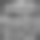

In [108]:
#делаем новые выборки

train_faces = []
train_not_faces = []

MAXSIZE = (40,40)
for elem in range(len(frames)):
  n = int(frames[elem][1])
  if n == 0:
      not_face= train[elem].crop((300, 300,300,300))
  
  for rect in range(n): 
    x, y, w, h = int(frames[elem][10 * rect + 2]),int(frames[elem][10 * rect + 3]),int(frames[elem][10 * rect + 4]),int(frames[elem][10 * rect + 5])

    face = (train[elem].crop((x, y,x + w,y + h))).resize(MAXSIZE, Image.LANCZOS)
    train_faces.append(face)

    not_face = (train[elem].crop((x + w, y + w,x + 2*w, y + 2*h))).resize(MAXSIZE, Image.LANCZOS)
    train_not_faces.append(not_face)

train_faces[0]

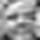

In [109]:
train_faces[44]


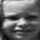

In [110]:
train_faces[66]

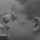

In [101]:
train_faces[432]

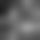

In [99]:
train_faces[675]

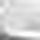

In [104]:
train_not_faces[5678]

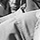

In [103]:
train_not_faces[9]

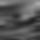

In [105]:
train_not_faces[8654]

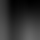

In [106]:
train_not_faces[65432]

#Признаки Хоара
##самый скучный блок кода

 Признаки я взяла из найденного раннее файла. Я скопировала n-строк, и там оказалось 109 признаков. Делать из 109 сто я, конечно, не буду:)

 формат хранения:
```
<features>  
  <_>
        <rects>
          <_>
            6 4 12 9 -1.</_>
          <_>
            6 7 12 3 3.</_></rects></_>
</features>
```
Представленный выше фрагмент описывает 1 признак Хоара, где прямоугольники задаются так:  
`<_> x1, y1, w, h, weight </_> `  
(верхний левый угол + ширина + высота + вес)  
  
более детальную информацию можно найти здесь:)  
https://api-2d3d-cad.com/viola-jones-method/

In [119]:
# займёмся признаками Хоара
from lxml import etree

h_features = []

#загрузим xml и распарсим его
with open('/content/drive/My Drive/Курсач/files/my_features.xml') as fobj:
  xml = fobj.read()
  root = etree.fromstring(xml)

  for elems in root.getchildren():
    for rects in elems.getchildren():
      rec = []
      for params in rects.getchildren():
        numbers = params.text[11:].split(" ")
        #переведём строки в int и float
        for i in range(len(numbers)-1):
          numbers[i] = int(numbers[i])
        numbers[len(numbers)-1] = float(numbers[len(numbers)-1])
        rec.append(numbers)
        #print(rec)
      h_features.append(rec)
print(h_features[0])

[[6, 4, 12, 9, -1.0], [6, 7, 12, 3, 3.0]]


#Ищем фичи
Самый ненадёжный блок на мой взгляд. Я прям чувствую, что он косячный:)   
В этом блоке формируется вектор признаков, который нам так нужен. Каким образом?  
Сольём наши картинки с лицами и без. Думаю, их ещё следует перемешать, а то у нас идёт 100 000 хороших картинок, а потом 100 000 не пойми чего, но пока я этого не делала. Далее бежим по новой мегавыборке и переводим изображения в интегральное представление. Я не нашла в pil готовой функции, вроде что-то есть в cv2, но я решила, что в предпросчёт матрицы я и сама могу. Потом я считала интенсивности по прямоугольникам и умножала на вес, который указан в параметрах каждого пр-ка( по идее можно просто считать разности значений перепада в черных и белых областях, но гугл сказал, что вес признака тоже стоит учесть:)). Один признак Хоара - это 2-3 прямоугольника. Причём что-то с положительными весами, что-то с отрицательными, и я так понимаю, это и есть что-то вроде градации на чёрное и белое (тк там где области накладываются, мы суммируем веса, а цвет опред.знаком), поэтому я просто суммирую все значения в рамках одного признака, умножив их на соответствующий вес, и получаю f_Xij.  
   
А ещё этот блок работает очень долго :) (около 12 мин) Это в принципе логично, тк внешний цикл работает >200 000 раз, а у него ещё куча внутренних

In [77]:
# подготовим изображения для получения признаков на нём
# и посчитаем признаки
 
many_faces = train_faces + train_not_faces
#формируем вектор признаков
f = []
k = 0
for images in many_faces:
 
  #интегральное представление изображения
  img = np.array(images,'uint8')
  matrix = np.zeros((MAXSIZE[0], MAXSIZE[1]))
  matrix[0][0]=img[0][0]
 
  for i in range (1, MAXSIZE[0]):
    matrix[i][0] += int(img[i][0]) +matrix[i-1][0]
  for i in range (1, MAXSIZE[1]):
    matrix[0][i] += int(img[0][i]) + matrix[0][i-1]
 
 
 
  for i in range (1, MAXSIZE[0]):
    for j in range (1, MAXSIZE[1]):
      matrix[i][j] += -matrix[i-1][j-1] + matrix[i-1][j] + matrix[i][j-1] + img[i][j]
 
 
  f_for_one_img = []
  for features in h_features:
    f_Xi = 0
    for rects in features:
      x1,y1,w,h,weight = rects[0], rects[1], rects[2], rects[3], rects[4]
      f_Xi += (matrix[y1-1+h][x1-1+w] - matrix[y1-1][x1-1+w] - matrix[y1-1+h][x1-1] + matrix[y1-1][x1-1])*weight
    f_for_one_img.append(f_Xi)
  f.append(f_for_one_img)
 
print(len(f))

205468


#Немного танцев с бубном
### Или последняя стадия подготовки данных для логистической регрессии
А теперь начинается самое интересное. У нас есть векторы признаков. Нужно найти вектор ответов.  
Если я правильно поняла, что из себя представляет логистическая регрессия, то наше множество ответов бинарно, т.е лицо/не лицо.  
Также я поняла, что нужно как-то проверить обученный алгоритм и посмотреть, насколько он силён в предсказаниях. А для этого нам нужна ещё выборка картинок. И я решила, что 200к - это достаточно много, и ничего не случится, если мы эту выборку разобьём на train и test. И здесь надо как-то красиво выкрутиться, тк сейчас у нас первая половина матрицы признаков - лица, а потом нет. Поэтому их нужно перемешать и не забыть, где же были лица:)  
 


#Блок-вопрос
> Нужна ли какая-то нормировка признаков или какое-то иное преобразование? В лекциях на coursera когда-то говорилось о том, что мб такое, что какие-то данные могут иметь очень большие или очень маленькие значения по сравнению с остальными данными, и это, естественно, влияет на качество обучения. И такие ситуации нужно контролировать.

In [118]:
import random

# финальный шаг в подготовке выборок

#массив индексов для перемешивания
id = np.arange(len(f), dtype= 'int64')
random.shuffle(id)
#print(id)

#создадим вектор ответов у, который мы позже разделим на train и test
y = np.array([1] * (len(f)//2) + [0] * (len(f)-len(f)//2))
y = y[id]

f = np.array(f)
f = f[id]

In [116]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier

#поделимся на train и test
xtrain, xtest, ytrain, ytest = train_test_split(f, y, test_size = 0.25, random_state = 0) 

#обучим классификатор
#classifier = LogisticRegression (random_state =0)
classifier = RandomForestClassifier(random_state = 0)
classifier.fit(xtrain, ytrain) 

#проверяем способность прогнозирования после обучения
y_pred = classifier.predict(xtest) 


#Блок-вопрос
>Что за предупреждение выскочило выше?)

# Получилось ???
Если что-то работает, то это ещё не значит, что это работает хорошо и правильно. Самое время попытаться осознать, а что же тут вообще получилось и получилось ли..

In [117]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score



cm = confusion_matrix(ytest, y_pred)
print (cm) 

# cm = [truePositive   falsePositive]
#      [falseNegative  trueNegative]

print ("Accuracy : ", accuracy_score(ytest, y_pred)) 

[[21079  4612]
 [ 6885 18791]]
Accuracy :  0.7761792590573715


#Примечание
После частичных исправлений я пересчитала точность логистической регресии, и она = 0.66...

#Вывод
Исходя из полученной оценки точности, можно сделать вывод, что данный алгоритм скорее напоминает гадалку, нежели крутую программу. Но что лучше: умение работать хоть как-то или умение работать хорошо?  
Что может быть лучше хороших навыков? Ничего. А попытка делать хоть как-то явно лучше, чем ничего :)

In [93]:
#блок для экспериментов, сюда можно не смотреть:)
image = np.array(train[0],'uint8')
print(image)
matrix = np.cumsum(image, dtype='int64', axis = (0, 1))
print(matrix)

[[ 49  50  51 ...  48  49  54]
 [ 41  41  42 ...  51  51  55]
 [ 40  40  40 ...  48  47  50]
 ...
 [136 138 139 ...  74 107 131]
 [136 138 139 ...  76 110 135]
 [136 138 139 ...  76 111 135]]


TypeError: ignored